In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
from free_flyer.utils import *
import pickle, os

In [2]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

# Regressor

In [3]:
from solvers.regression import Regression

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
reg_obj = Regression(system, prob, prob_features)

n_features = 36
reg_obj.construct_strategies(n_features, train_data)

In [4]:
reg_obj.setup_network()

fn_saved = 'models/regression_free_flyer_20200708_0809.pt'
reg_obj.load_network(fn_saved)

reg_obj.model

Loading presaved regression model from models/regression_free_flyer_20200708_0809.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=160, bias=True)
  )
)

In [ ]:
reg_obj.training_params['TRAINING_ITERATIONS'] = 500
reg_obj.train(verbose=True)
print(reg_obj.model_fn)

In [ ]:
n_succ = 0
count = 0

costs_reg = []
total_time_reg = []
num_solves_reg = []

cost_ratios_reg = []

for ii in range(n_test):
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, optvals = reg_obj.forward(prob_params)

        if prob_success:
            n_succ += 1
            costs_reg += [cost]
            total_time_reg += [total_time]
            num_solves_reg += [1]

            true_cost = c_test[ii]
            cost_ratios_reg += [cost / true_cost]
        count += 1
    except:
        continue

costs_reg = np.array(costs_reg)
cost_ratios_reg = np.array(cost_ratios_reg)
total_time_reg = np.array(total_time_reg)
num_solves_reg = np.array(num_solves_reg, dtype=int)

reg_percentage = 100 * float(n_succ) / float(count)
reg_percentage

In [17]:
reg_percentage

49.32

# MLOPT classifier

In [5]:
from solvers.coco import CoCo

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_obj = CoCo(system, prob, prob_features, n_evals=3)

n_features = 36
mlopt_obj.construct_strategies(n_features, train_data)
print(mlopt_obj.n_strategies)

67217


In [6]:
mlopt_obj.setup_network()

fn_saved = 'mlopt_free_flyer_20200707_1425.pt'
# fn_saved = 'None'
mlopt_obj.load_network(fn_saved)

mlopt_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=67217, bias=True)
  )
)

In [ ]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_obj.train(verbose=False)
print(mlopt_obj.model_fn)

In [ ]:
n_succ = 0
count = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = mlopt_obj.forward(prob_params)

        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_mlopt += [cost / true_cost]
        count += 1
    except:
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)
mlopt_percentage

0 / 10000


In [31]:
mlopt_percentage

8.23

# image encodings

In [7]:
from solvers.coco_ff import CoCo_FF

In [8]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles_map']

max_evals = 3
coco_obj = CoCo_FF(system, prob, prob_features)

n_features = 4
coco_obj.construct_strategies(n_features, train_data)
print(coco_obj.n_strategies)

458


In [9]:
coco_obj.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200706_0823.pt'  # old dataset
fn_saved = 'models/mloptff_free_flyer_20200716_0708.pt'   # New spaced out dataset
fn_saved = 'models/CoCoFF_free_flyer_20210125_0808.pt'
# fn_saved = 'mloptff_free_flyer_20200726_1455.pt'
coco_obj.load_network(fn_saved)

coco_obj.model

Loading presaved classifier model from models/CoCoFF_free_flyer_20210125_0808.pt


CNNet(
  (conv_activation): ReLU()
  (ff_activation): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (ff_layers): ModuleList(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=458, bias=True)
  )
)

In [ ]:
coco_obj.training_params['TRAINING_ITERATIONS'] = 750
coco_obj.train(train_data=train_data, verbose=True)

In [ ]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]

prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, solver=cp.MOSEK, max_evals=10)

if prob_success:
    print(n_evals)
else:
    print('Failed')

In [ ]:
n_succ = 0
count = 0
gurobi_mlopt_fail = 0

costs_coco = []
total_time_coco = []
num_solves_coco = []

cost_ratios_coco = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = coco_obj.forward(prob_params, max_evals=max_evals, solver=cp.MOSEK)

        if prob_success:
            n_succ += 1
            costs_coco += [cost]
            total_time_coco += [total_time]
            num_solves_coco += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_coco += [cost / true_cost]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_coco = np.array(costs_coco)
cost_ratios_coco = np.array(cost_ratios_coco)
total_time_coco = np.array(total_time_coco)
num_solves_coco = np.array(num_solves_coco, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

coco_percentage = 100 * float(n_succ) / float(count)

In [32]:
coco_percentage

91.94919491949194

# Martius & Zhu (2019)

In [10]:
from solvers.knn import KNN

In [11]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles']

knn_obj = KNN(system, prob, prob_features, knn=3)

n_features = 36
knn_obj.train(n_features, train_data)

In [ ]:
n_succ = 0
count = 0

costs_knn = []
total_time_knn = []
num_solves_knn = []

cost_ratios_knn = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = knn_obj.forward(prob_params, solver=cp.MOSEK)

        if prob_success:
            n_succ += 1
            costs_knn += [cost]
            total_time_knn += [total_time]
            num_solves_knn += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_knn += [cost / true_cost]
        count += 1
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        continue

costs_knn = np.array(costs_knn)
cost_ratios_knn = np.array(cost_ratios_knn)
total_time_knn = np.array(total_time_knn)
num_solves_knn = np.array(num_solves_knn, dtype=int)

knn_percentage = 100 * float(n_succ) / float(count)

0 / 10000


In [15]:
knn_percentage

48.6

# Mosek

### Make sure set value for max number of feasible solutions for solver

In [29]:
print('Cutoff time for Mosek: {}'.format(np.max(total_time_coco)))

Cutoff time for Mosek: 0.025114774703979492


In [30]:
solver = cp.MOSEK

n_succ = 0
count = 0

costs_sol = []
cost_ratios_sol = []
total_time_sol = []

for ii in range(n_test):
    count += 1
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, optvals = prob.solve_micp(prob_params, solver=solver)

        if prob_success:
            n_succ += 1
            costs_sol += [cost]

            true_cost = c_test[ii]
            cost_ratios_sol += [cost / true_cost]
            total_time_sol += [total_time]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
#         print('Solver failed at {}'.format(ii))
        continue

costs_sol = np.array(costs_sol)
cost_ratios_sol = np.array(cost_ratios_sol)
total_time_sol = np.array(total_time_sol)

sol_percentage = 100 * float(n_succ) / float(count)
sol_percentage

98.73

In [33]:
sol_percentage

98.73

# Results

In [44]:
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd
import h5py
import matplotlib

flierprops = {'alpha':0.2}

params = {'backend': 'ps',
              'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
              'font.size': 90, # was 12 and before 10
              'legend.fontsize': 12, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
              'text.usetex': True,
              'font.family': 'serif',
              'font.sans-serif':['Helvetica Neue']
    }

params = {
#     'backend': 'ps',
#               'text.latex.preamble': ['\\usepackage{gensymb}'],
#               'axes.labelsize': 12, # fontsize for x and y labels (was 12 and before 10)
#               'axes.titlesize': 12,
#               'font.size': 12, # was 12 and before 10
              'legend.fontsize': 26, # was 12 and before 10
#               'xtick.labelsize': 12,
#               'ytick.labelsize': 12,
#               'text.usetex': True,
#               'font.family': 'serif',
#               'font.sans-serif':['Helvetica Neue']
    }

sns.set(font_scale=2.)
matplotlib.rcParams.update(params)

In [50]:
# hf = h5py.File('free_flyer_dev.h5', 'w')

# hf.create_dataset('percentage', data=np.expand_dims(np.asarray([sol_percentage, coco_percentage, mlopt_percentage, reg_percentage, knn_percentage]), axis=1))

# num_solves_grp = hf.create_group('num_solves')
# num_solves_grp.create_dataset('num_solves_coco', data=np.expand_dims(num_solves_coco, axis=1))
# num_solves_grp.create_dataset('num_solves_mlopt', data=np.expand_dims(num_solves_mlopt, axis=1))
# num_solves_grp.create_dataset('num_solves_reg', data=np.expand_dims(num_solves_reg, axis=1))
# num_solves_grp.create_dataset('num_solves_knn', data=np.expand_dims(num_solves_knn, axis=1))

# total_time_grp = hf.create_group('total_time')
# total_time_grp.create_dataset('total_time_sol', data=np.expand_dims(total_time_sol, axis=1))
# total_time_grp.create_dataset('total_time_coco', data=np.expand_dims(total_time_coco, axis=1))
# total_time_grp.create_dataset('total_time_mlopt', data=np.expand_dims(total_time_mlopt, axis=1))
# total_time_grp.create_dataset('total_time_reg', data=np.expand_dims(total_time_reg, axis=1))
# total_time_grp.create_dataset('total_time_knn', data=np.expand_dims(total_time_knn, axis=1))

# cost_ratios_grp = hf.create_group('cost_ratios')
# cost_ratios_grp.create_dataset('cost_ratios_sol', data=np.expand_dims(cost_ratios_sol, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_coco', data=np.expand_dims(cost_ratios_coco, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_mlopt', data=np.expand_dims(cost_ratios_mlopt, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_reg', data=np.expand_dims(cost_ratios_reg, axis=1))
# cost_ratios_grp.create_dataset('cost_ratios_knn', data=np.expand_dims(cost_ratios_knn, axis=1))

# hf.close()

In [4]:
hf = h5py.File('free_flyer_dev.h5', 'r')

num_solves_grp = hf.get('num_solves')
num_solves_coco = np.squeeze(np.array(num_solves_grp.get('num_solves_coco')))
num_solves_mlopt = np.squeeze(np.array(num_solves_grp.get('num_solves_mlopt')))
num_solves_reg = np.squeeze(np.array(num_solves_grp.get('num_solves_reg')))
num_solves_knn = np.squeeze(np.array(num_solves_grp.get('num_solves_knn')))

total_time_grp = hf.get('total_time')
total_time_sol = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_sol'))))
total_time_coco = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_coco'))))
total_time_mlopt = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_mlopt'))))
total_time_reg = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_reg'))))
total_time_knn = np.ndarray.tolist(np.squeeze(np.array(total_time_grp.get('total_time_knn'))))

cost_ratios_grp = hf.get('cost_ratios')
cost_ratios_sol = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_sol')))
cost_ratios_coco = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_coco')))
cost_ratios_mlopt = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_mlopt')))
cost_ratios_reg = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_reg')))
cost_ratios_knn = np.squeeze(np.array(cost_ratios_grp.get('cost_ratios_knn')))

sol_percentage, coco_percentage, mlopt_percentage, reg_percentage, knn_percentage = np.ndarray.tolist(np.squeeze(np.array(hf.get('percentage'))))

hf.close()

In [15]:
print(reg_percentage)
print(knn_percentage)

49.32
48.6


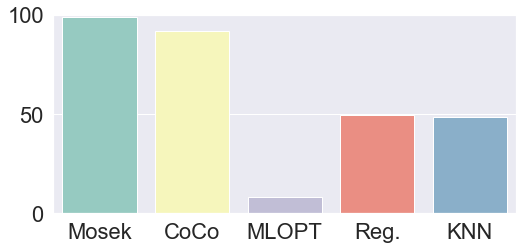

In [45]:
results = {'Mosek':[sol_percentage], 'CoCo':[coco_percentage], 'MLOPT':[mlopt_percentage], 'Reg.':[reg_percentage], 'KNN':[knn_percentage]}
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.ylim(0,100)
plt.tight_layout()

ax1 = sns.barplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")
ax1.set(xlabel="", ylabel="")

sns.set(font_scale=2.5)
figure = ax1.get_figure()
figure.savefig("free_flyer_percent_success.png", bbox_inches='tight')

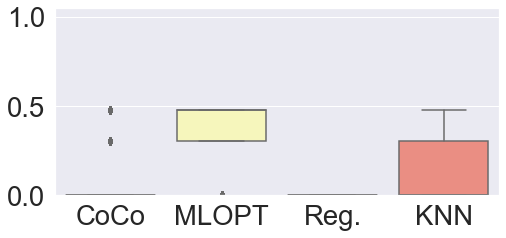

In [46]:
results = {}
results['Policy'] = ['CoCo']*len(num_solves_coco) + ['MLOPT']*len(num_solves_mlopt) + ['Reg.']*len(num_solves_reg) + ['KNN']*len(num_solves_knn)
results['Solves'] = np.hstack((np.log10(num_solves_coco), np.log10(num_solves_mlopt), np.log10(num_solves_reg), np.log10(num_solves_knn)))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.ylim(0,1.05)
plt.tight_layout()

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(QPs Solved)")
ax1.set(xlabel="", ylabel="")

sns.set(font_scale=2.5)
figure = ax1.get_figure()
figure.savefig("free_flyer_solved.png", bbox_inches='tight')

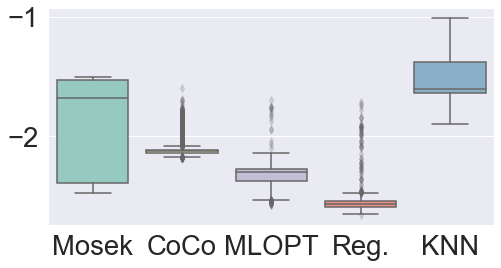

In [47]:
results = {}
results['Policy'] = ['Mosek']*len(total_time_sol) +  ['CoCo']*len(total_time_coco) + ['MLOPT']*len(total_time_mlopt) + ['Reg.']*len(total_time_reg) + ['KNN']*len(total_time_knn)
results['Time'] = np.hstack((np.log10(total_time_sol), np.log10(total_time_coco), np.log10(total_time_mlopt), np.log10(total_time_reg), np.log10(total_time_knn)))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.tight_layout()

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(Time) [s]")
ax1.set(xlabel="", ylabel="")

sns.set(font_scale=2.5)
figure = ax1.get_figure()
figure.savefig("free_flyer_time.png", bbox_inches='tight')

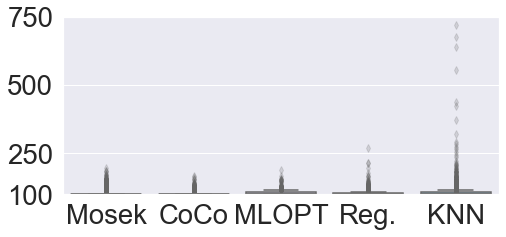

In [48]:
results = {}
results['Policy'] = ['Mosek']*len(cost_ratios_sol) + ['CoCo']*len(cost_ratios_coco) + ['MLOPT']*len(cost_ratios_mlopt) + ['Reg.']*len(cost_ratios_reg) + ['KNN']*len(cost_ratios_knn)
results['Costs'] = np.hstack((100*cost_ratios_sol, 100*cost_ratios_coco, 100*cost_ratios_mlopt, 100*cost_ratios_reg, 100*cost_ratios_knn))
results = pd.DataFrame(results)

plt.figure(figsize=(8,4))
plt.ylim(99,140)
# plt.yticks([100, 250, 500, 750])
plt.tight_layout()

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="Relative Cost [%]")
ax1.set(xlabel="", ylabel="")

sns.set(font_scale=2.5)
figure = ax1.get_figure()
figure.savefig("free_flyer_cost.png", bbox_inches='tight')

In [ ]:
print('sol_percentage: {}'.format(sol_percentage))
print('coco_percentage: {}'.format(coco_percentage))
print('reg_percentage: {}'.format(reg_percentage))
print('knn_percentage: {}'.format(knn_percentage))

In [ ]:
timeout_idx_coco = np.where(total_time_coco <= 0.01)[0]
timeout_idx_reg = np.where(total_time_reg <= 0.01)[0]
timeout_idx_knn = np.where(total_time_knn <= 0.01)[0]
timeout_idx_sol = np.where(total_time_sol <= 0.01)[0]

In [ ]:
plt.plot(1000*np.sort(total_time_coco[timeout_idx_coco]), linestyle='--', label='CoCo')
plt.plot(1000*np.sort(total_time_sol[timeout_idx_sol]), linestyle='--', label='Mosek')
plt.xlabel('Problem Index')
plt.ylabel('Time [ms]')
plt.ylim([0,12])
plt.legend(loc='best')

In [ ]:
# results = {'Gurobi':[100.], 'MLOPT':[mlopt_percentage], 'CNN':[cnn_percentage]}
# results = {'Gurobi':[100.], 'MLOPT':[mlopt_percentage], 'Regressor':[reg_percentage], 'KNN':[knn_percentage]}
results = {'Mosek':[sol_percentage], 'CoCo':[coco_percentage], 'Regressor':[reg_percentage], 'KNN':[knn_percentage]}
results = {'Mosek':[100*float(len(timeout_idx_sol))/float(n_test)], \
           'CoCo':[100*float(len(timeout_idx_coco))/float(n_test)], \
           'Regressor':[100*float(len(timeout_idx_reg))/float(n_test)], \
           'KNN':[100*float(len(timeout_idx_knn))/float(n_test)]}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3", label='small')
ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
figure.savefig("percent_success.pdf")

In [ ]:
results = {}
results['Policy'] = ['MLOPT']*len(num_solves_mlopt) + ['CNN']*len(num_solves_cnn)
results['Solves'] = np.hstack((np.log10(num_solves_mlopt), np.log10(num_solves_cnn)))


results['Policy'] = ['CoCo']*len(num_solves_cnn) + ['Regressor']*len(num_solves_reg) + ['KNN']*len(num_solves_knn)
results['Solves'] = np.hstack((np.log10(num_solves_cnn), np.log10(num_solves_reg), np.log10(num_solves_knn)))

results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(QCQPs Solved)")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

In [ ]:
results = {}
# results['Policy'] = ['Gurobi']*len(total_time_ip) + ['MLOPT']*len(total_time_mlopt) + \
#     ['CNN']*len(total_time_cnn)
# results['Time'] = np.hstack((np.log10(total_time_ip), \
#     np.log10(total_time_mlopt), np.log10(total_time_cnn)))

results['Policy'] = ['Mosek']*len(total_time_sol[timeout_idx_sol]) + ['CoCo']*len(total_time_cnn[timeout_idx_cnn]) + \
    ['Regressor']*len(total_time_reg[timeout_idx_reg]) + ['KNN']*len(total_time_knn[timeout_idx_knn])
results['Time'] = np.hstack((np.log10(total_time_sol[timeout_idx_sol]), \
    np.log10(total_time_cnn[timeout_idx_cnn]), np.log10(total_time_reg[timeout_idx_reg]), np.log10(total_time_knn[timeout_idx_knn])))

results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="log(Time) [s]")

plt.tight_layout()

figure = ax1.get_figure()
figure.savefig("time.pdf")

In [ ]:
results = {}
# results['Policy'] = ['Gurobi']*len(costs_ip) + \
#     ['MLOPT']*len(cost_ratios_mlopt) + ['CNN']*len(cost_ratios_cnn)
# results['Costs'] = np.hstack((100*np.ones(len(costs_ip)), \
#     100*cost_ratios_mlopt, 100*cost_ratios_cnn))

# results['Policy'] = ['Gurobi']*len(costs_ip) + \
#     ['CNN']*len(cost_ratios_cnn) + ['Regressor']*len(cost_ratios_reg) + ['KNN']*len(cost_ratios_knn)
# results['Costs'] = np.hstack((100*np.ones(len(costs_ip)), \
#     100*cost_ratios_cnn, 100*cost_ratios_reg, 100*cost_ratios_knn))
# results['Costs'] = np.hstack((np.log10(np.ones(len(costs_ip))), \
#     np.log10(cost_ratios_cnn), np.log10(cost_ratios_reg), np.log10(cost_ratios_knn)))

results['Policy'] = ['Mosek']*len(cost_ratios_sol[timeout_idx_sol]) + \
    ['CoCo']*len(cost_ratios_coco[timeout_idx_coco]) + ['Regressor']*len(cost_ratios_reg[timeout_idx_reg]) + ['KNN']*len(cost_ratios_knn)
results['Costs'] = np.hstack((100*cost_ratios_sol[timeout_idx_sol], 100*cost_ratios_coco[timeout_idx_coco], \
        100*cost_ratios_reg[timeout_idx_reg], 100*cost_ratios_knn))

results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="Relative Cost [%]")
# ax1.set(xlabel="", ylabel="log(Relative Cost)")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(costs_ip, cost_ratios_cnn, cost_ratios_reg, cost_ratios_knn)) / 10.0)) * 10)
plt.ylim([100., 400])

figure = ax1.get_figure()
figure.savefig("cost.pdf")